In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

#import jax functions
import jax.numpy as jnp
from jax import jit
from jax.scipy.stats import norm
from jax.lax import fori_loop
from jax.ops import index_update

from tqdm.notebook import tqdm

# Copula update plot (Fig 2)

In [3]:
#return c_uv and H_uv from copula plots

def cop_update(u,v,a):
    u_ = 1-u
    v_ = 1-v
    k = (a+1)/a
    cop_dens = k*u_**(-k)*v_**(-k)/(u_**(-1/a) + v_**(-1/a)-1)**(a+2)
    cop_dist = 1-((v_**(-k))/((u_**(-1/a) + v_**(-1/a)-1)**(a+1)))
    return cop_dens,cop_dist

In [4]:
y_plot = np.arange(0,5,0.01)

#Initialize cdf
P0 = sp.stats.expon.cdf(y_plot)
p0 = sp.stats.expon.pdf(y_plot)

#New data point
y1 = 2
v1 = P0[np.argmin(np.abs(y1-y_plot))]

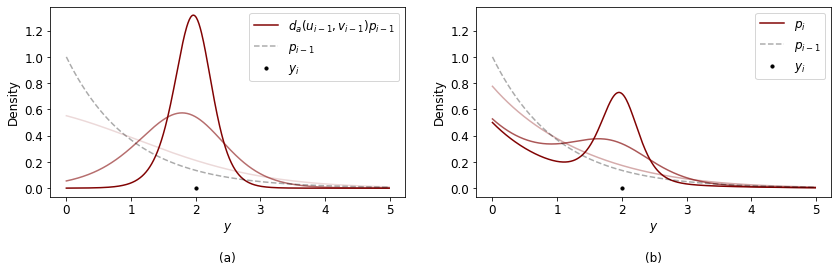

In [5]:
f =plt.figure(figsize=(14,3.5))
#f =plt.figure(figsize=(7,4))

a_range = np.array([0.2,0.5,2])
plt.subplot(1,2,1)

alpha = 0.5

#plt.plot(y_plot,p0)
plt.scatter([y1],[0], s= 10, color = 'k',label = '$y_{i}$')


#plot first to get legend
j = 0.99
c_uv,H_uv = cop_update(P0,v1,a_range[0])
plt.plot(y_plot,c_uv*p0, color = 'maroon', alpha = j,label = r'$d_a(u_{i-1},v_{i-1}) p_{i-1}$')
j= j- 0.42
for a in a_range[1:]:
    c_uv,H_uv = cop_update(P0,v1,a)
    plt.plot(y_plot,(c_uv)*p0, color = 'maroon', alpha = j)
    j = j - 0.42
    
plt.plot(y_plot,p0,label= r'$p_{i-1}$', color = 'k', linestyle = '--',alpha = 0.33)
plt.xticks(fontsize=12)
plt.yticks(fontsize = 12)
plt.xlabel('$y$\n \n(a)',fontsize = 12)
plt.ylabel(r'Density',fontsize = 12)
plt.legend(loc = 1,fontsize = 12)
ylim = plt.ylim()
xlim = plt.xlim()

plt.subplot(1,2,2)

alpha = 0.5

#plt.plot(y_plot,p0)
plt.scatter([y1],[0], s= 10, color = 'k',label = r'$y_{i}$')


#plot first to get legend
j = 0.99
c_uv,H_uv = cop_update(P0,v1,a_range[0])

plt.plot(y_plot,(1-alpha+alpha*c_uv)*p0, color = 'maroon', alpha = j,label = r'$p_{i}$')
j= j- 0.33
for a in a_range[1:]:
    c_uv,H_uv = cop_update(P0,v1,a)
    plt.plot(y_plot,(1-alpha+alpha*c_uv)*p0, color = 'maroon', alpha = j)
    j = j - 0.33
    
plt.plot(y_plot,p0,label= r'$p_{i-1}$', color = 'k', linestyle = '--',alpha = 0.33)
plt.xticks(fontsize=12)
plt.yticks(fontsize = 12)
plt.xlabel('$y$ \n \n(b)',fontsize = 12)
plt.ylabel(r'Density',fontsize = 12)
plt.legend(loc = 1,fontsize = 12)
plt.xlim(xlim)
plt.ylim(ylim)
f.savefig('plots/cop_illustration_3a.pdf', bbox_inches='tight')